## Pregunta 3 Reconocimiento de Imágenes en CIFAR10

CIFAR10. Se trata de un conjunto de 60.000 imágenes RGB de 32 x 32 pixeles que contiene 10 clases de objetos (6000 ejemplos por clase). Está separado en 50000 ejemplos de entrenamiento y 10000 casos de prueba. El conjunto de pruebas fue obtenido seleccionando 1000 imágenes aleatorias de cada clase. Los datos restantes han sido ordenados aleatoriamente y están organizados en 5 bloques de entrenamiento (batches) donde cada batch puede tener más o menos imágenes de una determinada clase, pero en total existen 5000 imágenes de cada clase en el conjunto de entrenamiento. 

Las clases son mutuamente excluyentes y corresponden a las siguientes categorías: gato, perro, rana, caballo, pájaro, ciervo, avión, automóvil, camión y barco.

#### Se extraen los diccionarios

Cada diccionario contiene 2 elementos importantes: data y labels. El primer elemento (data) es un matriz de 10000 x 3072 (numpy array). Cada fila de esa matriz corresponde a una imagen RGB: los primeros 1024 valores vienen del canal R, los siguientes 1024 del canal G, y los últimos 1024 del canal B.

Para cada canal, las imágenes han sido vectorizadas por filas, de modo que los primeros 32 valores del canal R corresponden a la primera fila de la imagen. Por otro lado, el elemento (labels) del diccionario contiene una lista de 1000 valores enteros entre 0 y 9 que identifican las clases antes enumeradas.

In [1]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### a) Creación de los conjuntos de datos

Para la creación de los conjuntos de entrenamiento, pruebas y validación se generan las matrices $X_{tr}$, $X_{te}$ y $X_{v}$ respectivamente. El conjunto de validación corresponde a una muestra aleatoria del conjunto de pruebas, y corresponde a 10.000 imágenes que no necesariamente tienen  la misma cantidad de imágenes de cada clase.

In [2]:
from scipy.misc import imread
import cPickle as pickle
import numpy as np
import os
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

def load_CIFAR_one(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f)
        X = datadict['data']
        Y = datadict['labels']
        return X, np.array(Y, dtype=int)

def load_CIFAR10(PATH):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_one(f)
        xs.append(X)
        ys.append(Y)
    Xtemp = np.concatenate(xs)
    Ytemp = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_one(os.path.join(PATH, 'test_batch'))
    Xtr, Xv, Ytr, Yv = train_test_split(Xtemp, Ytemp, test_size=0.2, random_state=0)
    del Xtemp, Ytemp
    return Xtr, Ytr, Xte, Yte, Xv, Yv
#you need to add Xval
Xtr, Ytr, Xte, Yte, Xv, Yv = load_CIFAR10('.')

### b) Escalamiento

Las dos formas más utilizadas para escalar datos corresponden a rescaling y standarization.  En  rescaling la idea es llevar los datos al rango [0,1], esto permite que no existan problemas asociados a las dimensiones de los datos, sin embargo, aún pueden quedar valores en diferentes órdenes de magnitud.

$$x' = \frac{x - \text{min}(x)}{\text{max}(x)-\text{min}(x)}$$

Standarization por su parte, asume que cada feature de los datos puede ser de naturaleza completamente distinta, por lo mismo, para cada feature calcula su media y su desviación estándar para aplicar la siguiente formula:

$$x' = \frac{x - \bar{x}}{\sigma}$$

Donde $x'$ representa el vector de una característica. Lo que logra standarization, es que cada feature tenga media cero y varianza unitaria, lo cual es muy bueno para la mayoría de los algoritmos de aprendizaje que dependen de la escala de los datos.

In [11]:
from sklearn.preprocessing import StandardScaler

def scaler_function(Xtr,Xt,Xv,scale=True, type='estandar'):
    if(type=='estandar'):
        scaler = StandardScaler(with_std=scale).fit(Xtr)
        Xtr_scaled = scaler.transform(Xtr)
        Xt_scaled = scaler.transform(Xt)
        Xv_scaled = scaler.transform(Xv)
    elif(type=='intensidad_maxima'):
        Xtr_scaled = np.divide(Xtr,255.)
        Xt_scaled = np.divide(Xt,255.)
        Xv_scaled = np.divide(Xv,255.)
    return Xtr_scaled, Xt_scaled, Xv_scaled

Using Theano backend.


In [ ]:
#Xtr, Xte, Xv = scaler_function(Xtr,Xte,Xv, type='estandar')
#Xtr, Xte, Xv = scaler_function(Xtr,Xte,Xv, type='intensidad_maxima')

from keras.utils.np_utils import to_categorical

Ytr = to_categorical(Ytr)
Yte = to_categorical(Yte)
Yv = to_categorical(Yv)

### c) Red Neuronal

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

def do_ann(Xtr, Ytr, Xte, Yte, Xv, Yv):
    model = Sequential()
    model.add(Dense(100, input_dim=Xtr.shape[1], init='uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, init='uniform', activation='softmax'))
    model.compile(optimizer=SGD(lr=0.05), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(Xtr, Ytr, nb_epoch=50, batch_size=32, verbose=0, validation_data=(Xv,Yv))
    
    scores = model.evaluate(Xtr, Ytr)
    train_acc = scores[1]
    scores = model.evaluate(Xv, Yv)
    val_acc = scores[1]
    scores = model.evaluate(Xte, Yte)
    test_acc = scores[1]
    
    print "\nAccuracy de train: %f"%(train_acc)
    print "Accuracy de validacion: %f"%(val_acc)
    print "Accuracy de test: %f"%(test_acc)

In [14]:
do_ann(Xtr, Ytr, Xte, Yte, Xv, Yv)   

 9952/10000 [============================>.] - ETA: 0s
Accuracy de train: 0.926967
Accuracy de validacion: 0.917700
Accuracy de test: 0.917680


### d) Red Neuronal: extract_features

Los histogramas de tono, son representaciones de las distintas tonalidades presentes en una imagen. Lo que muestran, son la frecuencia de colores a través de los pixeles de la imagen, según el rango de color en el que se encuentran. La ventaja que presentan, es que se pueden extraer las características más relevantes de la imagen en términos de color, según su frecuencia de aparición.

<img src ="histograma.jpg" />

Por su parte, los descriptores HOG ( Histogram Oriented Gradient), toman en cuenta la apariencia y la forma del objeto local dentro de una imagen que pueden describirse mediante la distribución de gradientes de intensidad  y  direcciones de borde. La imagen se divide en pequeñas regiones conectadas, y para los píxeles dentro de cada celda, se compila un histograma de direcciones de gradiente. El descriptor es la concatenación de estos histogramas. Habitualmente son utilizados para detección de objetos y especialmente para detección de imágenes de humanos.

<img src ="hog.gif" />


In [6]:
Xtr, Ytr, Xte, Yte, Xv, Yv = load_CIFAR10('.')
Ytr = to_categorical(Ytr)
Yte = to_categorical(Yte)
Yv = to_categorical(Yv)

#### Feature: Histograma de Tono

In [10]:
from top_level_features import color_histogram_hsv
from top_level_features import hog_features
from top_level_features import extract_features
features_train = extract_features(Xtr,[color_histogram_hsv]) #extrae histogramas de color
features_test = extract_features(Xte,[color_histogram_hsv]) #extrae histogramas de color
features_val = extract_features(Xv,[color_histogram_hsv]) #extrae histogramas de color

print Xtr.shape
print features_train.shape

(40000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)


In [11]:
do_red_neuronal(features_train, Ytr, features_test, Yte, features_val, Yv)

 9664/10000 [===========================>..] - ETA: 0s
Accuracy de train: 0.900000
Accuracy de validacion: 0.900000
Accuracy de test: 0.900000


#### Feature: Descriptores HOG

In [12]:
features_train = extract_features(Xtr,[hog_features]) #extrae hog features
features_test = extract_features(Xte,[hog_features]) #extrae hog features
features_val = extract_features(Xv,[hog_features]) #extrae hog features

print Xtr.shape
print features_train.shape

(40000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(40000L, 3072L)
(40000L, 144L)


In [13]:
do_red_neuronal(features_train, Ytr, features_test, Yte, features_val, Yv)

 9824/10000 [============================>.] - ETA: 0s
Accuracy de train: 0.939175
Accuracy de validacion: 0.923140
Accuracy de test: 0.923400


#### Feature: Híbrido (HOG e Histograma)

In [14]:
features_train = extract_features(Xtr,[hog_features, color_histogram_hsv]) #extrae todo
features_test = extract_features(Xte,[hog_features, color_histogram_hsv]) #extrae todo
features_val = extract_features(Xv,[hog_features, color_histogram_hsv]) #extrae todo

print Xtr.shape
print features_train.shape

(40000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(40000L, 3072L)
(40000L, 154L)


In [15]:
do_red_neuronal(features_train, Ytr, features_test, Yte, features_val, Yv)

 9856/10000 [============================>.] - ETA: 0s
Accuracy de train: 0.941618
Accuracy de validacion: 0.925220
Accuracy de test: 0.925630


### e) SVM No-Lineal

En primer lugar se debe resaltar que Kenalizar una SVM tiene un costo elevado de aproximadamente $O(n_{features} \times n^{2}_{data})$. Además en la documentación de sklearn expecifica que para data sets con más de 10000 datos es difícil de escalar ([scikit-learn: SVM](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)). Lo cual vuelve inviable la utilizan de una SVM no lineal en este problema, ya que se tienen 40000 datos de entrenamiento y 3072 caráctiristicas. Por lo tanto se opto por reducir el conjunto de datos a 10000.

In [39]:
Xtr, Ytr, Xte, Yte, Xv, Yv = load_CIFAR10('.')
Xtr= Xtr[0:10000]
Ytr = Ytr[0:10000]
Xtr, Xte, Xv = scaler_function(Xtr,Xte,Xv, type='intensidad_maxima')

In [42]:
from sklearn.svm import SVC

def do_SVM_no_lineal(x,y,xt,yt,xv,yv,model_type,best):
    Cs = np.logspace(-2, 4,base=2, num=7)
    acc_val = []
    models = []
    for C in Cs:
        if model_type == 'rbf':
            clf = SVC(C=C, kernel='rbf')
        elif model_type == 'poly':
            clf = SVC(C=C, kernel='poly',degree=2, coef0=1)

        clf=clf.fit(x,y)
                
        acc_val.append(clf.score(xv,yv))
        models.append(clf)

    if best:
        best_ = acc_val.index(max(acc_val))
        C_b = Cs[best_]
        model_b = models[best_]
        print "Mejor parámetro de regularización C: %s"%(C_b)
        print "Mejor Accuracy de validación: %f"%(max(acc_val))
        print "\nAccuracy de entrenamiento: %f"%(model_b.score(x,y))
        print "Accuracy de prueba: %f"%(model_b.score(xt,yt))
        
        plt.figure(figsize=(10,5))
        ax = plt.gca()
        #ax.plot(Cs,acc_tr,label='Accuracy train')
        ax.plot(Cs,acc_val,label=u'Accuracy validación')
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.xlabel('C', fontsize= 16)
        plt.ylabel('Accuracy', fontsize= 16)
        plt.title('SVM no Lineal con kernel %s'%(model_type), fontsize= 20)
        ax.set_xscale('linear')
        plt.show()

Mejor parámetro de regularización C: 4.0
Mejor Accuracy de validación: 0.489700

Accuracy de entrenamiento: 0.957200
Accuracy de prueba: 0.487100


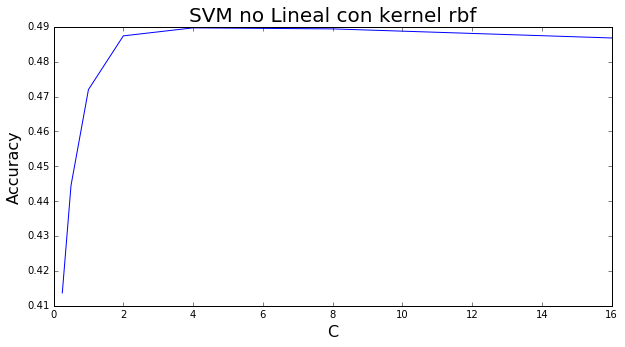

SVC(C=4.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [8]:
do_SVM_no_lineal(Xtr, Ytr, Xte, Yte, Xv, Yv, 'rbf', best=True)

In [ ]:
do_SVM_no_lineal(Xtr, Ytr, Xte, Yte, Xv, Yv, 'poly', best=True)

#### Feature: Histograma de Tono

In [40]:
features_train = extract_features(Xtr,[color_histogram_hsv]) #extrae histogramas de color
features_test = extract_features(Xte,[color_histogram_hsv]) #extrae histogramas de color
features_val = extract_features(Xv,[color_histogram_hsv]) #extrae histogramas de color

(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)


Mejor parámetro de regularización C: 16.0
Mejor Accuracy de validación: 0.245200

Accuracy de entrenamiento: 0.256900
Accuracy de prueba: 0.253200


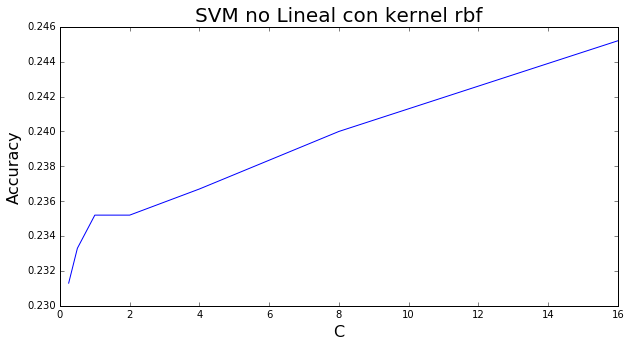

In [44]:
do_SVM_no_lineal(features_train, Ytr, features_test, Yte, features_val, Yv, 'rbf', best=True)
#do_SVM_no_lineal(features_train, Ytr, features_test, Yte, features_val, Yv, 'poly', best=True)

#### Feature: Descriptores HOG

In [45]:
features_train = extract_features(Xtr,[hog_features]) #extrae hog features
features_test = extract_features(Xte,[hog_features]) #extrae hog features
features_val = extract_features(Xv,[hog_features]) #extrae hog features

(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)


Mejor parámetro de regularización C: 16.0
Mejor Accuracy de validación: 0.100700

Accuracy de entrenamiento: 0.108900
Accuracy de prueba: 0.103000


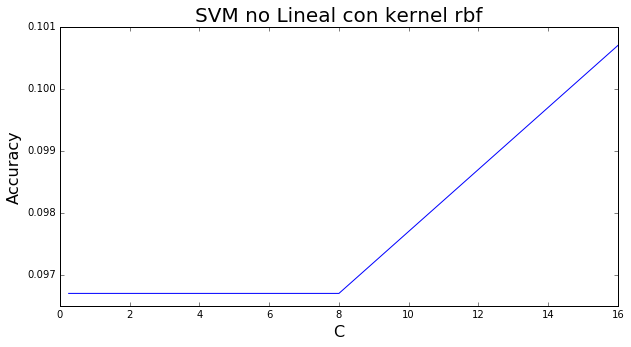

In [46]:
do_SVM_no_lineal(features_train, Ytr, features_test, Yte, features_val, Yv, 'rbf', best=True)
#do_SVM_no_lineal(features_train, Ytr, features_test, Yte, features_val, Yv, 'poly', best=True)

#### Feature: Híbrido (HOG e Histograma)

In [47]:
features_train = extract_features(Xtr,[hog_features, color_histogram_hsv]) #extrae todo
features_test = extract_features(Xte,[hog_features, color_histogram_hsv]) #extrae todo
features_val = extract_features(Xv,[hog_features, color_histogram_hsv]) #extrae todo

(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)


Mejor parámetro de regularización C: 16.0
Mejor Accuracy de validación: 0.254600

Accuracy de entrenamiento: 0.261000
Accuracy de prueba: 0.251900


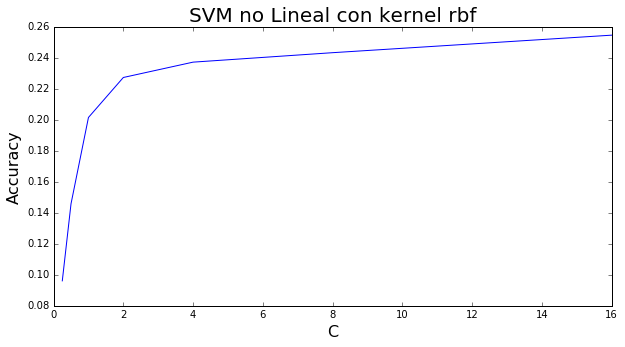

In [48]:
do_SVM_no_lineal(features_train, Ytr, features_test, Yte, features_val, Yv, 'rbf', best=True)
#do_SVM_no_lineal(features_train, Ytr, features_test, Yte, features_val, Yv, 'poly', best=True)

#### SVM son Inviables o.ó

### f) Árbol de clasificación

Para la realización de los experimentos con árboles, no se considera estandarización de los datos, ya que los arboles no se ven influenciados mayormente por este tipo de pre procesamiento. Se prueban valores de la profundidad del árbol, correspondiente al parámetro $\textit{max_depth}$ entre 2 y 20 sobre el conjunto de validación con el objetivo de obtener los mejores resultados antes de evaluar en el set de pruebas.

Como ocurrió anteriormente, se prueban los árboles en diferentes datos de entrenamiento considerando los atributos de alto nivel producidos por la extracción de características.


In [18]:
Xtr, Ytr, Xte, Yte, Xv, Yv = load_CIFAR10('.')

In [19]:
from sklearn.tree import DecisionTreeClassifier as Tree

def do_Tree(x,y,xt,yt,xv,yv):
    N_ts = np.linspace(2, 20, num=20)
    acc_val = []
    models = []
    for n_t in N_ts:
        clf=Tree(criterion='gini',splitter='best',random_state=0,max_depth=n_t)
        clf=clf.fit(x,y)
        acc_val.append(clf.score(xv,yv))
        models.append(clf)
    best_ = acc_val.index(max(acc_val))            
    model_best = models[best_]
    
    print "Profundidad del mejor árbol = %d"%model_best.tree_.max_depth
    print "Mejor Accuracy de validación: %f"%(max(acc_val))
    print "\nAccuracy de entrenamiento: %f"%(model_best.score(x,y))
    print "Accuracy de prueba: %f"%(model_best.score(xt,yt))
    
    plt.figure(figsize=(10,5))
    ax = plt.gca()
    #ax.plot(N_ts,acc_tr,label='Accuracy train')
    ax.plot(N_ts,acc_val,label=u'Accuracy validación')

    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('N_t', fontsize= 16)
    plt.ylabel('Accuracy validación', fontsize= 16)
    plt.title(u'Árbol de clasificación con múltiples niveles', fontsize= 20)
    ax.set_xscale('linear')
    plt.show()

Profundidad del mejor árbol = 9
Mejor Accuracy de validación: 0.298300

Accuracy de entrenamiento: 0.390000
Accuracy de prueba: 0.302000


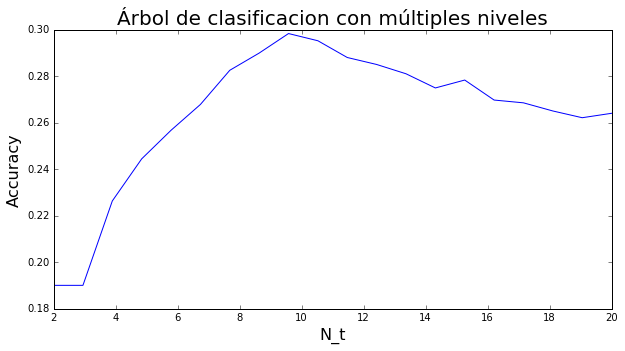

In [20]:
do_Tree(Xtr, Ytr, Xte, Yte, Xv, Yv)

Como se observa, la profundidad del mejor árbol corresponde a 9, además el mejor accuracy de validación es 0.298300. Considerando tanto el accuracy de entrenamiento y pruebas, se observa que el árbol generaliza en mayor medida, sin embargo los resultados obtenidos son bastante malos, considerando que una predicción aleatoria puede entregar mejores resultados. El grafico muestra como a medida que aumenta la profundidad del árbol, el accuracy es creciente, hasta llegar a 9 niveles de profundidad. Luego, la accuracy decrece significativamente, esto puede  deberse a que las reglas son demasiado específicas, es decir, el sobre ajuste crece considerablemente con cada nivel añadido.

#### Feature: Histograma de Tono

In [21]:
features_train = extract_features(Xtr,[color_histogram_hsv]) #extrae histogramas de color
features_test = extract_features(Xte,[color_histogram_hsv]) #extrae histogramas de color
features_val = extract_features(Xv,[color_histogram_hsv]) #extrae histogramas de color

(40000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)


Profundidad del mejor árbol = 9
Mejor Accuracy de validación: 0.250000

Accuracy de entrenamiento: 0.308525
Accuracy de prueba: 0.258100


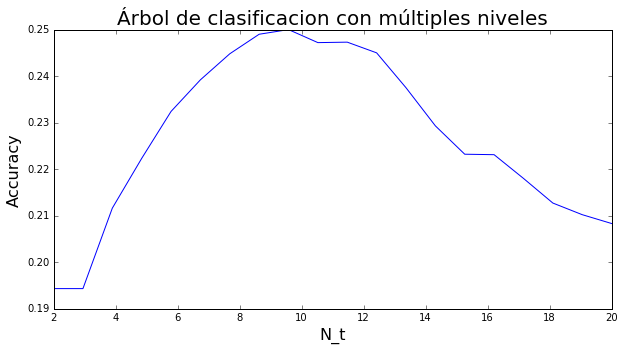

In [22]:
do_Tree(features_train, Ytr, features_test, Yte, features_val, Yv)

El histograma de tonos, conserva solo 10 características, lo cual puede afectar negativamente a los resultados, debido a que se pierde mucha información sobre las imágenes. Nuevamente, la mejor profundidad para el árbol es 9, y el mejor accuracy de validación es 0.25. Con este parámetro, se obtiene un accuracy en el set de pruebas de 0.258100, aproximadamente 4% menor al caso anterior. Esto, es aún peor que los resultados obtenidos con la totalidad de los datos. 

El grafico es similar al anterior, lo cual indica que esta técnica de extracción de características no es apropiada en este caso. Esto puede deberse principalmente a que la extracción de características mediante histograma de color, solo analiza los colores como función principal para describir un objeto, esto sin embargo, para este problema no es muy conveniente, debido a que por ejemplo pueden existir autos o animales de distintos colores, y por lo mismo el color no es algo particularmente representativo de clases tan genéricas.

#### Feature: Descriptores HOG

In [23]:
features_train = extract_features(Xtr,[hog_features]) #extrae hog features
features_test = extract_features(Xte,[hog_features]) #extrae hog features
features_val = extract_features(Xv,[hog_features]) #extrae hog features

(40000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)


Profundidad del mejor árbol = 9
Mejor Accuracy de validación: 0.285800

Accuracy de entrenamiento: 0.368350
Accuracy de prueba: 0.283800


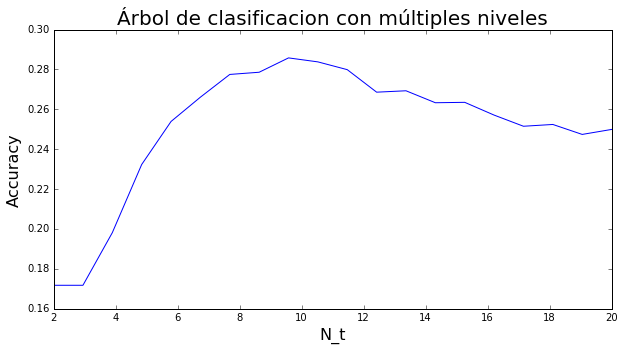

In [24]:
do_Tree(features_train, Ytr, features_test, Yte, features_val, Yv)

Como ocurre en casos anteriores, el mejor parámetro es 9 niveles de profundidad del árbol. Notar que los descriptores HOG, conservan 144 características, que es un número  bastante pequeño comparado con el conjunto de entrenamiento original.  Los resultados nuevamente no son para nada positivos, con valores de 0.285800 para el set de validación y 0.283800 para el conjunto de pruebas.

A pesar que los descriptores HOG sirven para el reconocimiento de patrones estructurales y objetos, utilizando arboles no se nota una mejora significativa, esto puede ser producto a que los arboles no son buenos para realizar clasificaciones sobre conjuntos de datos con mucha varianza, ya que son afectados por la jerarquía de las características. Esto es, si una imagen cambia ligeramente algún conjunto pequeño de pixeles, el árbol cambiara completamente, lo cual produce que las predicciones no sean acertadas.

#### Feature: Híbrido (HOG e Histograma)

In [25]:
features_train = extract_features(Xtr,[hog_features, color_histogram_hsv]) #extrae todo
features_test = extract_features(Xte,[hog_features, color_histogram_hsv]) #extrae todo
features_val = extract_features(Xv,[hog_features, color_histogram_hsv]) #extrae todo

(40000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)
(10000L, 32L, 32L, 3L)


Profundidad del mejor árbol = 10
Mejor Accuracy de validación: 0.317800

Accuracy de entrenamiento: 0.443925
Accuracy de prueba: 0.314200


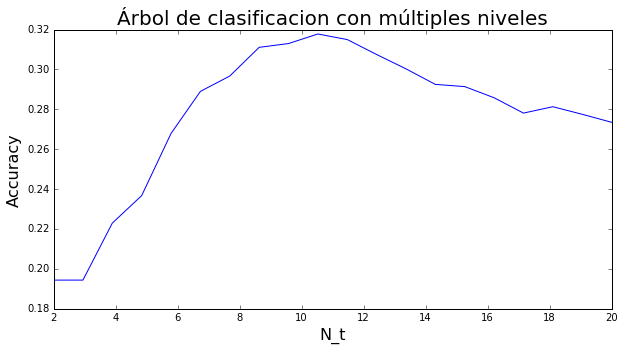

In [26]:
do_Tree(features_train, Ytr, features_test, Yte, features_val, Yv)

La combinación de ambos métodos, genera 154 características, y en ese caso el mejor parámetro corresponde a 10 niveles de profundidad del árbol. Un detalle importante es que en ese caso el accuracy sobre el set de validación es 0.317800, y el de entrenamiento es 0.443925, con lo cual ya existe cierta cantidad de sobre ajuste del modelo. Por otra parte, el accuracy del set de pruebas es 0.314200, que comparado con los descriptores anteriores y la matriz original de entrenamiento, no mejora mucho más de un 1% , que está dentro de un rango de incertidumbre posible de los datos, y no puede ser especialmente atribuido a una mejora por las técnicas aplicadas.

Con los anteriores resultados, es claro que los arboles de clasificación, sin importar las técnicas usadas para mejorar su desempeño, no son indicados para desempeñar la tarea de clasificación de imágenes, debido a que no están preparados para lidiar con problemas que contengan datos variantes, ya que la inferencia de reglas es fija y al introducir imágenes con pequeñas variantes, el árbol no es capaz de determinar estos cambios. Los 4 gráficos utilizados son similares, por lo mismo, se establece que el comportamiento de los arboles no cambia mayormente al utilizar las técnicas de extracción de atributos.